# Praca domowa 5

## Budowa modelu

W tej pracy domowej skupiliśmy się na budowie modelu dla wybranej bazy danych. Jako jedną z baz wybraliśmy `Chest X-Ray Images (Pneumonia)`. Do budowy modelu wykorzystaliśmy bibliotekę `tensorflow`.

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import random
import numpy as np

In [5]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob

In [60]:

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [6]:
from tensorflow import keras
import tensorflow as tf

## Zapis zdjęć do ramki danych

In [7]:
train_path = '../Warsztaty/chest_xray/train/'
test_path = '../Warsztaty/chest_xray/test/'
val_path = '../Warsztaty/chest_xray/val/'

In [8]:
def df_from_dir(path):
    path_to_nrm = os.path.join(path+'/NORMAL')
    path_to_pn = os.path.join(path+'/PNEUMONIA')
    
    list_class_nrm = [0] * len(os.listdir(path_to_nrm))
    list_class_pn = [1] * len(os.listdir(path_to_pn))
    
    list_path_nrm = [os.path.join(path_to_nrm, filename) for filename in os.listdir(path_to_nrm)]
    list_path_pn = [os.path.join(path_to_pn, filename) for filename in os.listdir(path_to_pn)]
    
    return pd.DataFrame({'path': list_path_nrm + list_path_pn, 'class': list_class_nrm + list_class_pn})

In [9]:
train_df = df_from_dir(train_path)
valid_add_df = df_from_dir(test_path)
test_df = df_from_dir(val_path)

In [10]:
y_test=valid_add_df['class']
y_train=train_df['class']

In [11]:
import cv2

In [12]:
new_size=224    
X_train = []

for file in  train_df['path'] :  
    orignal_image = cv2.imread(file)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
        
    resized_image = cv2.resize(image , (new_size,new_size))
    X_train.append(resized_image)

In [13]:
new_size=224    
X_test = []

for file in valid_add_df['path'] :  
    orignal_image = cv2.imread(file)
    image = cv2.cvtColor(orignal_image, cv2.COLOR_BGR2RGB)
        
    resized_image = cv2.resize(image , (new_size,new_size))
    X_test.append(resized_image)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [15]:
X_test = np.array(X_test)
y_test = np.array(y_test)

## Budowa modelu Resnet-50

In [17]:
from keras.models import load_model
from keras.layers import Activation, Dense

In [18]:
from tensorflow.keras.optimizers import Adam

In [21]:
from tensorflow.keras.applications.resnet50 import ResNet50

model = ResNet50(include_top=False, input_shape=(224, 224, 3), weights = 'imagenet')

for layer in model.layers[:70]:
    layer.trainable = False

for layer in model.layers[70:]:
    layer.trainable = True

In [35]:
model = Sequential([ Conv2D(32,3, padding = "same", activation = "relu" ,input_shape=(224, 224, 3)), MaxPooling2D(2,2),

Conv2D(64,3, padding = "same",activation = "relu"),
MaxPooling2D(2,2),

Conv2D(128,3, padding = "same",activation = "relu"),
MaxPooling2D(2,2),

Conv2D(128,3, padding = "same",activation = "relu"),
MaxPooling2D(2,2),
Dropout(rate=0.2),

Conv2D(128,3, padding = "same",activation = "relu"),
MaxPooling2D(2,2),


Conv2D(128,3, padding = "same",activation = "relu"),
MaxPooling2D(2,2),

Flatten(),

Dropout(rate=0.5),

Dense(512,activation = "relu"),

Dense(1, activation ='sigmoid')
])

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 16

train_data_gen = ImageDataGenerator(
                                 # rescale = 1./255,
                                #shear_range = 0.2,
                                fill_mode='nearest',
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                height_shift_range=0.2,
                                width_shift_range=0.2,
                                horizontal_flip=True, 
                                rotation_range = 20,   

                               )

test_data_gen  = ImageDataGenerator()

test = test_data_gen.flow(
      X_test,
      y_test,
      shuffle=True, 
      batch_size=batch_size
      )
train = train_data_gen.flow(
      X_train,
      y_train,
      shuffle=True, 
      batch_size=batch_size
      )

In [26]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger, LearningRateScheduler,TensorBoard,CallbackList

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout,BatchNormalization,SeparableConv2D

In [30]:
earlystop=EarlyStopping(patience=15)
filepath = "pneum_or_not.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,save_best_only=True, mode='max')
log_fname = 'model_pneum_or_not.csv'
csv_logger = CSVLogger(filename=log_fname,separator=',',append=False)
callbacks_list = [checkpoint, csv_logger,earlystop] 
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

In [37]:
opt=tf.keras.optimizers.Adam(0.0001)
model.compile(optimizer=opt,loss='binary_crossentropy' , metrics='accuracy')

In [38]:
history= model.fit(train,validation_data=test,epochs=15,verbose=1,batch_size=32,callbacks=[callbacks_list,lr_reduce])

Epoch 1/15
326/326 [==============================] - ETA: 0s - loss: 0.8424 - accuracy: 0.7176
Epoch 1: val_accuracy improved from -inf to 0.62821, saving model to pneum_or_not.h5
326/326 [==============================] - 287s 879ms/step - loss: 0.8424 - accuracy: 0.7176 - val_loss: 0.8669 - val_accuracy: 0.6282 - lr: 1.0000e-04
Epoch 2/15
326/326 [==============================] - ETA: 0s - loss: 0.4240 - accuracy: 0.8021
Epoch 2: val_accuracy improved from 0.62821 to 0.81410, saving model to pneum_or_not.h5
326/326 [==============================] - 289s 885ms/step - loss: 0.4240 - accuracy: 0.8021 - val_loss: 0.4541 - val_accuracy: 0.8141 - lr: 1.0000e-04
Epoch 3/15
326/326 [==============================] - ETA: 0s - loss: 0.3551 - accuracy: 0.8393
Epoch 3: val_accuracy did not improve from 0.81410

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
326/326 [==============================] - 296s 908ms/step - loss: 0.3551 - accuracy: 0.8393 - val_loss: 0

## Wnioski po trenowaniu

Proces treningu został ustawiony na 15 epok. Okazało się, że maksymalną dokładność na zbiorze testowym otrzymaliśmy już po 9 epokach. Otrzymany wynik w okolicach 89% wydaje się dosyc wysoki i zachęca do korzystania z modelu.

## Wykresy dokładności

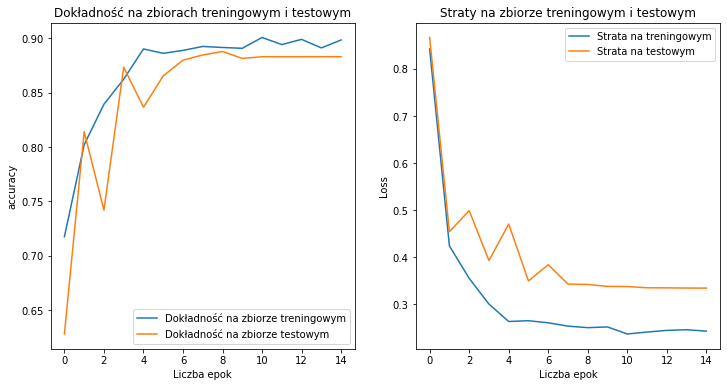

In [61]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(15)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Dokładność na zbiorze treningowym')
plt.plot(epochs_range, val_acc, label='Dokładność na zbiorze testowym')
plt.legend(loc='lower right')
plt.title('Dokładność na zbiorach treningowym i testowym')
plt.xlabel('Liczba epok')
plt.ylabel('accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Strata na treningowym')
plt.plot(epochs_range, val_loss, label='Strata na testowym')
plt.legend(loc='upper right')
plt.title('Straty na zbiorze treningowym i testowym')
plt.xlabel('Liczba epok')
plt.ylabel('Loss')
plt.show()

Pierwszy wykres potwierdza obserwcję, że wystarczy 9 epok, nie trzeba trenować dłużej. Drugi wykres przedstawiający straty pokazuje, że model można byłoby jeszcze dotrenować, ponieważ krzywe straty na zbiorze treningowym i testowym nie są bardzo blisko siebie. 

In [41]:
prediction = model.predict(X_test)
prediction = np.where(prediction>0.5, 1, 0)
metrics = model.evaluate(X_test, y_test)
from sklearn.metrics import classification_report

print(classification_report(y_test, prediction))

20/20 [==============================] - 9s 449ms/step - loss: 0.3343 - accuracy: 0.8830
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       234
           1       0.91      0.90      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



W naszym przypadku najważniejszą miarą było `accuracy`. Wynikało to z liczby zdjęć w poszczególnych kategoriach. Jednak widzimy, że wszystkie miary wskazują dokładność na poziomie około 90%. 

In [51]:
from sklearn.metrics import plot_confusion_matrix

20/20 [==============================] - 9s 441ms/step


Text(0.5, 145.31999999999996, 'Predicted')

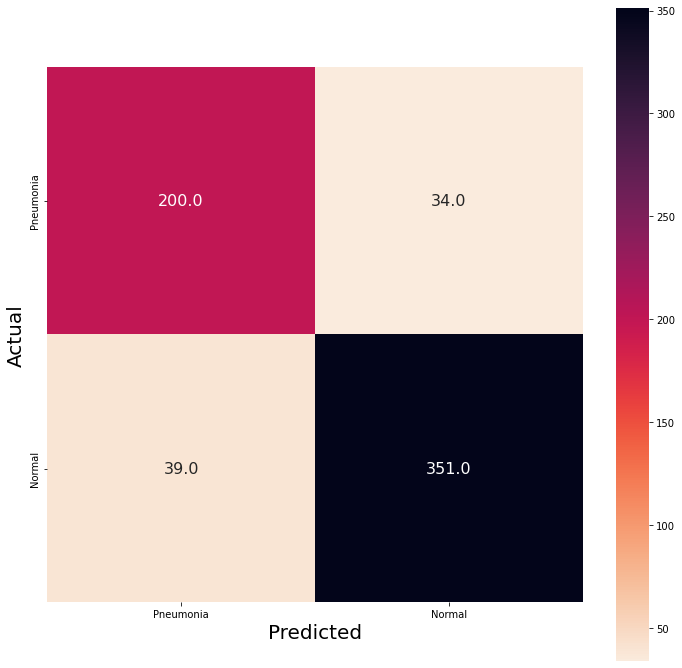

In [59]:
label=['Pneumonia','Normal']
prediction = model.predict(X_test)
prediction = np.where(prediction>0.5, 1, 0)

cm = confusion_matrix(y_test,prediction)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

Ostatni z wykresów przedstawia macierz pomyłek. Model popełnia podobną liczbę pomyłek w obu przypadkach.

### Wykorzystane artykuły:
- https://towardsdatascience.com/image-classification-using-tensorflow-in-python-f8c978824edc
- https://www.pluralsight.com/guides/introduction-to-densenet-with-tensorflow
- https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays

# Zbiór danych nr 2
## Pediatric Chest X-Ray Pneumonia

In [69]:
import os
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [71]:
from torchvision.io import read_image

In [72]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

### Utworzenie ramki danych z nazwą każdego pliku i klasą do której należy.

In [73]:
train_path = "D:\\Datasets\\Pediatric Chest X-ray Pneumonia\\train\\"
train_filenames = []
train_annotations = []

for filename in os.scandir(train_path):
    if filename.is_dir() and filename.name == "NORMAL":
        for filename_ in os.scandir(train_path + filename.name + "\\"):
            train_filenames.append(filename_.name)
            train_annotations.append(0)
    elif filename.is_dir() and filename.name == "PNEUMONIA":
        for filename_ in os.scandir(train_path + filename.name + "\\"):
            train_filenames.append(filename_.name)
            train_annotations.append(1)

train_dict = {"filename": train_filenames, "annotation": train_annotations}

### Analogiczne do powyższych działania dla zbioru testowego.

In [74]:
test_path = "D:\\Datasets\\Pediatric Chest X-ray Pneumonia\\test\\"
test_filenames = []
test_annotations = []

for filename in os.scandir(test_path):
    if filename.is_dir() and filename.name == "NORMAL":
        for filename_ in os.scandir(test_path + filename.name + "\\"):
            test_filenames.append(filename_.name)
            test_annotations.append(0)
    elif filename.is_dir() and filename.name == "PNEUMONIA":
        for filename_ in os.scandir(test_path + filename.name + "\\"):
            test_filenames.append(filename_.name)
            test_annotations.append(1)

test_dict = {"filename": test_filenames, "annotation": test_annotations}

In [75]:
classes = ("NORMAL", "PNEUMONIA")

### Wymiar do którego przeskalowane zostaną wszystkei obrazki w celu ujednolicenia rozmiarów.

In [79]:
min_size = (128, 128)

### Utworzenie klasy TrainDataset i TestDataset pozwalających na korzystanie z własnych danych w API pyTorchowym.
#### W tym fragmencie kodu deklarowany jest również biało-czarny sposób wczytywania obrazków oraz skalowanie odcienia szarości z wartości 0-255 do wartości 0-1.

In [80]:
class TrainDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame.from_dict(train_dict)
        self.img_dir = train_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path, torchvision.io.ImageReadMode.GRAY).float()
        label = self.img_labels.iloc[idx, 1]
        image = torch.div(image, 255)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [81]:
class TestDataset(Dataset):
    def __init__(self, transform=None, target_transform=None):
        self.img_labels = pd.DataFrame.from_dict(test_dict)
        self.img_dir = test_path
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path, torchvision.io.ImageReadMode.GRAY).float()
        image = torch.div(image, 255)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

### Zmniejszenie wszystkich obrazków do wspólnego wymiaru w celu przyśpieszenia uczenia i ujednolicenia zbioru danych.

In [82]:
transform = transforms.Compose(
    [torchvision.transforms.Resize(min_size)])

training_data = TrainDataset(transform=transform)
test_data = TestDataset(transform=transform)

### Utworzenie instancji DataLoadera niezbędnego do korzystania z pyTorchowego API.

In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

### Przykładowy obrazek po transformacji z odpowiednią etykietą.

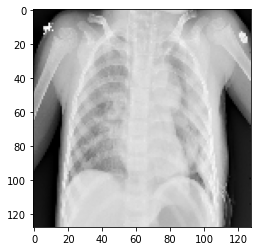

PNEUMONIA


In [84]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(1)))

### Zadeklarowanie architektury sieci 

In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(8, 8)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### Wybranie optimalizatora i funckji straty

In [89]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

### Uczenie sieci

In [94]:
for epoch in range(4):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.579
[1,  4000] loss: 0.578
[2,  2000] loss: 0.568
[2,  4000] loss: 0.588
[3,  2000] loss: 0.575
[3,  4000] loss: 0.580
[4,  2000] loss: 0.571
[4,  4000] loss: 0.581
Finished Training


### Ewaluacja sieci na zbiorze testowym

In [97]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on test images: {100 * correct // total} %')

Accuracy of the network on test images: 62 %


Sieć osiąga accuracy klasyfikacji na poziomie 62%. Wynik ten sam w sobie nie jest imponujący. Na dodatek kiedy zaczniemy się bliżej przyglądać predykcjom modelu, zauważymy, że model dla każdego obrazka wskazuje klasę 1 (Pneumonia). Accuracy na poziomie 62% wynika właśnie z niedokońca zbalansowanych klas w zbiorze testowym. Niestety pomimo wielu godzin spędzonych na debugowaniu sieci nie byliśmy w stanie dojść do źródła problemu. Niezależnie jakich transformacji byśmy nie zastosowali nie byliśmy w stanie zmienić zachowania sieci.

### Wykorzystane źródła:
- https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html
- https://github.com/alexkhrustalev/DS_projects/blob/master/cats_and_dogs.py